# Data Visualization & Model Building

## Loading Autovit.ro scraped data

In [1]:
# required imports
import gzip
import json
import os
import re

# multi-array stuff
import pandas as pd
import numpy as np

# plot stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sea

# import and set no warnigns
import warnings
warnings.filterwarnings('ignore')

# set pd no max cols rows (to show all)
# pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999

raw_adverts = []
for root, dirs, files in os.walk('../database/autovit/adverts/'):
    for name in files:
        file = os.path.join(root, name)
        with gzip.open(file, 'r') as fin:
            raw_adverts.extend(json.loads(fin.read().decode('utf-8')))

raw_adverts[0].pop('photos', None)
print('** Loaded {} adverts **'.format(len(raw_adverts)))

** Loaded 7032 adverts **


## Parsing / shaping scraped data

In [2]:
def strip_nr(str_nr):
    if str_nr is not None:
        return int(re.sub(r'[^0-9]+', '', str_nr))
    else:
        raise TypeError
    
def get_listing_param(data, name):
    for p in data['listing_params']:
        if p[0] == name:
            return p[1]
    else:
        return None

reshaped_adverts = []
i = 0
for ad in raw_adverts:
    # Ad has req data, essential
    if 'list_label' in ad \
        and get_listing_param(ad, 'Anul fabricatiei') is not None \
        and get_listing_param(ad, 'Kilometraj') is not None \
        and get_listing_param(ad, 'Combustibil') is not None \
        and 'features' in ad \
        and 'params' in ad:
        
        # reshape params data
        if 'params' in ad:
            for p in ad['params']:
                ad[p[0]] = p[1]
            # pop extra params
            ad.pop('params', None)

        # reshape features
        if 'features' in ad:
            for f in ad['features']:
                ad[f] = True
            # pop extra features
            ad.pop('features', None)

        # format price as int only
        if 'list_label' in ad:
            ad['price'] = strip_nr(ad['list_label'])
            ad.pop('list_label', None)
        else:
            print('No list label')


        ad['fabrication_year'] = strip_nr(get_listing_param(ad, 'Anul fabricatiei'))
        ad['kilometers'] = strip_nr(get_listing_param(ad, 'Kilometraj'))
        ad['fuel'] = get_listing_param(ad, 'Combustibil').lower()
        ad['brand_model'] = '{}-{}'.format(ad['Marca'], ad['Model'])
        
        # Params
        hp = ad['Putere'] if 'Putere' in ad else None
        if hp is not None:
            hp = strip_nr(hp.replace('CP', ''))
            ad['horse_power'] = hp
            
        co2 = ad['Emisii CO2'] if 'Emisii CO2' in ad else None
        if co2 is not None:
            co2 = strip_nr(co2.replace('g/km', ''))
            ad['emissions'] = co2

        # Listing params
        cc = get_listing_param(ad, 'Capacitate cilindrica')
        if cc is not None:
            cc = strip_nr(cc.replace('cm3', ''))
            ad['cubic_capacity'] = cc

        # pop unused keys
        ad.pop('photos', None)
        ad.pop('description', None)

        reshaped_adverts.append(ad)

print('** Parsed usable adverts: {} **'.format(len(reshaped_adverts)))

** Parsed usable adverts: 5978 **


## Data info

In [3]:
df = pd.DataFrame(reshaped_adverts)
df.describe()

,age,highlighted,urgent,topAd,category_id,business,hide_user_ads_button,dealer_logo_in_results,dealer_logo_in_ad_page,has_phone,has_email,map_radius,map_private_radius_size,ad_featured,price,fabrication_year,kilometers,horse_power,cubic_capacity,emissions
count,5978.000000,5978.0,5978.0,5978.000000,5978.0,5978.000000,5978.0,5978.000000,5978.000000,5950.0,5978.0,5978.000000,5978.0,5978.0,5978.000000,5978.000000,5.978000e+03,5883.000000,5844.000000,3607.000000
mean,73.058213,0.0,0.0,0.031783,29.0,0.520074,0.0,0.400301,0.440616,1.0,1.0,0.046504,2.0,0.0,17377.373369,2013.342088,1.483706e+05,162.681795,1976.293806,140.852232
std,160.324325,0.0,0.0,0.175437,0.0,0.499639,0.0,0.490000,0.496502,0.0,0.0,0.210591,0.0,0.0,22749.813616,4.867621,9.624664e+04,77.790251,603.966113,43.967619
min,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,450.000000,1982.000000,1.000000e+00,2.000000,599.000000,1.000000
25%,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,5612.500000,2010.000000,7.703475e+04,110.000000,1598.000000,114.000000
50%,28.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,9999.000000,2014.000000,1.576000e+05,149.000000,1968.000000,135.000000
75%,72.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.000000,2.0,0.0,19900.000000,2017.000000,2.120000e+05,190.000000,1999.000000,159.000000
max,4039.000000,0.0,0.0,1.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,1.000000,2.0,0.0,416500.000000,2021.000000,2.200000e+06,780.000000,6749.000000,1329.000000


## Data columns

In [4]:
df.head()

,id,region_id,region_name,city_id,city_name,district_id,district_name,new_used,url,preview_url,...,Valoare rata lunara,Numar de rate lunare ramase,Tuning,brand_program_id,brand_program_small_logo,Avariata,Valoare reziduala,,Masina de epoca,Volan pe dreapta
0,7044521275,2,Cluj,52953,Cluj-Napoca,,,used,https://www.autovit.ro/anunt/chevrolet-captiva...,https://www.autovit.ro/i2/anunt/chevrolet-capt...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7044541354,46,Bucuresti - Ilfov,1,Bucuresti,7,Sectorul 4,used,https://www.autovit.ro/anunt/mercedes-benz-e-I...,https://www.autovit.ro/i2/anunt/mercedes-benz-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7043670835,46,Bucuresti - Ilfov,1,Bucuresti,1,Sectorul 1,used,https://www.autovit.ro/anunt/peugeot-508-ID7GG...,https://www.autovit.ro/i2/anunt/peugeot-508-ID...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7044544811,46,Bucuresti - Ilfov,1,Bucuresti,7,Sectorul 4,used,https://www.autovit.ro/anunt/volkswagen-transp...,https://www.autovit.ro/i2/anunt/volkswagen-tra...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7044544826,46,Bucuresti - Ilfov,1,Bucuresti,5,Sectorul 3,used,https://www.autovit.ro/anunt/peugeot-308-blueh...,https://www.autovit.ro/i2/anunt/peugeot-308-bl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Available brands

In [5]:
df['Marca'].unique()

array(['Chevrolet', 'Mercedes-Benz', 'Peugeot', 'Volkswagen', 'BMW',
       'Renault', 'Dacia', 'Audi', 'Ford', 'Skoda', 'Volvo', 'Jeep',
       'Opel', 'Porsche', 'Land Rover', 'Mazda', 'Toyota', 'Lexus',
       'Jaguar', 'Hyundai', 'Dodge', 'Seat', 'Fiat', 'Subaru', 'Honda',
       'Smart', 'Nissan', 'Kia', 'Tesla', 'Citroën', 'Mini', 'Chrysler',
       'Alfa Romeo', 'Mitsubishi', 'Suzuki', 'SsangYong', 'Daihatsu',
       'Ferrari', 'Daewoo', 'Maserati', 'Infiniti', 'Lancia', 'Saab',
       'DS Automobiles', 'Cadillac', 'McLaren', 'Aston Martin', 'Rover',
       'Bentley', 'Rolls-Royce', 'Lamborghini', 'Abarth'], dtype=object)

## Available models

In [6]:
df['Model'].unique()

array(['Captiva', 'E', '508', 'Transporter', '308', 'Seria 3', 'Kangoo',
       'CLS', 'Duster', 'Q5', 'Passat', 'Focus', 'Octavia', 'Jetta',
       'XC 40', 'Grand Cherokee', 'Seria 5', 'Astra', 'CLA', 'Macan',
       'Megane', 'Cayenne', 'Range Rover Sport', 'Insignia', 'Transit',
       'Golf', 'C', 'A4', 'Mondeo', 'Mokka', 'Tiguan', 'CX-5', 'Ranger',
       'Q3', 'Talisman', 'RAV4', 'Karoq', 'S', 'Sharan', 'A', 'AMG',
       'Fiesta', 'Seria IS', 'A3', 'XE', 'Freelander', 'Wrangler', 'I30',
       'Grand Scenic', 'X6', 'RAPID', 'Kodiaq', 'Transit Custom ', 'RAM',
       'Touareg', 'V40', 'T-Cross', 'X4', 'C-MAX', 'A7', 'GLE Coupe',
       'Seria 2 ', 'Yeti', 'X1', 'Corsa', 'X4 M', 'CX-3', 'Kamiq',
       'Zafira', 'Leon', 'KA', '5', 'X3', 'Polo', 'Caravelle', 'Scenic',
       'Captur', '500', 'Forester', '5008', 'CR-V', 'XC 60', 'Fortwo',
       'LEAF', 'S60', 'ML', 'A6', 'T-ROC', 'Renegade', 'Kuga', 'GLE',
       'i3', 'Golf Plus', 'X6 M', 'Seria 7', 'Amarok', 'GLC Coupe',
       

In [7]:
print(sorted(df['fabrication_year'].unique()))

[1982, 1983, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1997, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


### Visualizing brand prices

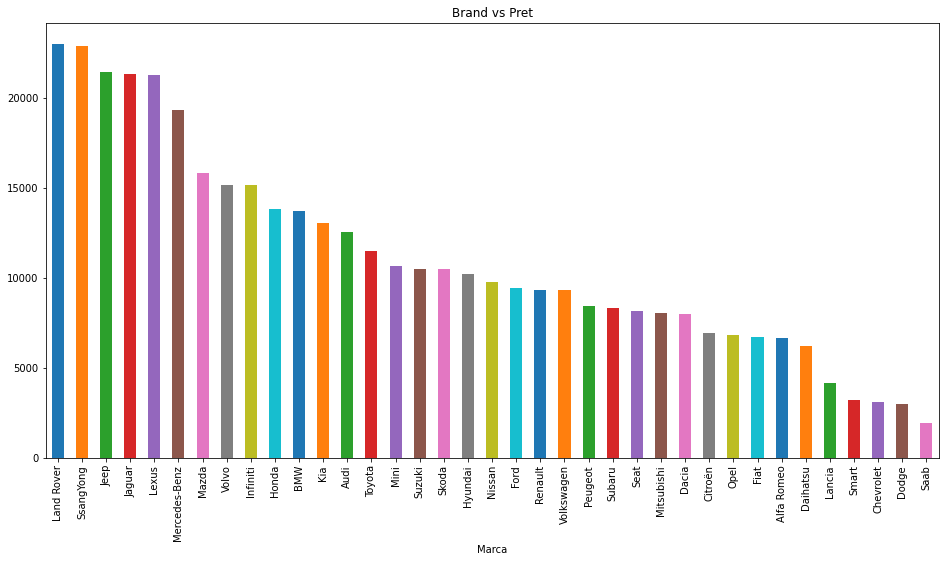

In [62]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, (1, 4))
df_brand = df.groupby(['Marca'])['price'].mean().sort_values(ascending = False)
df_brand.plot(
    title='Brand vs Pret',
    xlabel="Marca",
    kind="bar",
    color=plt.cm.tab10(np.arange(len(df['Marca'])) % plt.cm.tab10.N)
)
plt.show()

### Visualizing regional prices

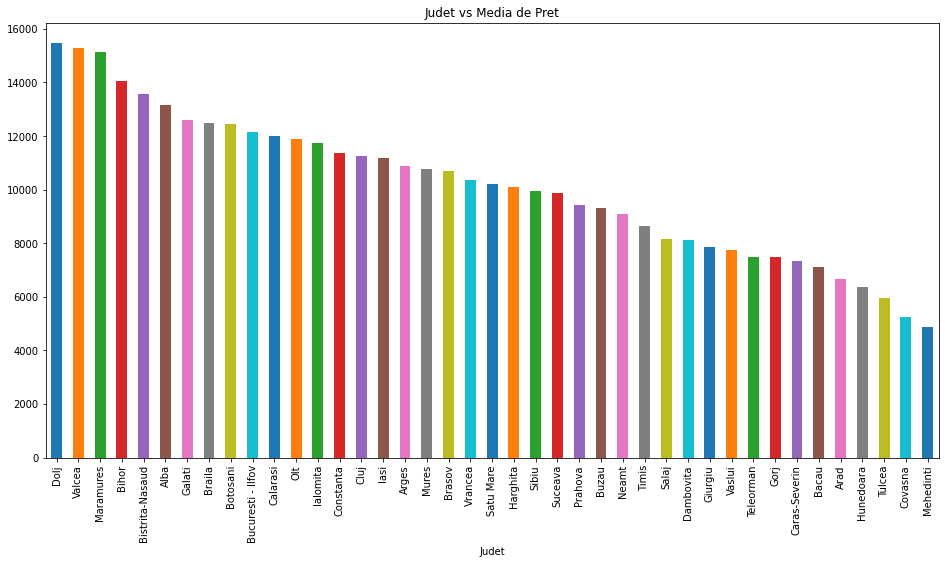

In [64]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, (1, 2))
df_cc = df.groupby(['region_name'])['price'].mean().sort_values(ascending = False)
df_cc.plot(
    title='Judet vs Media de Pret',
    xlabel="Judet",
    kind="bar",
    color=plt.cm.tab10(np.arange(len(df.region_name)) % plt.cm.tab10.N)
)
plt.show()

### Visualizing fuel tech prices

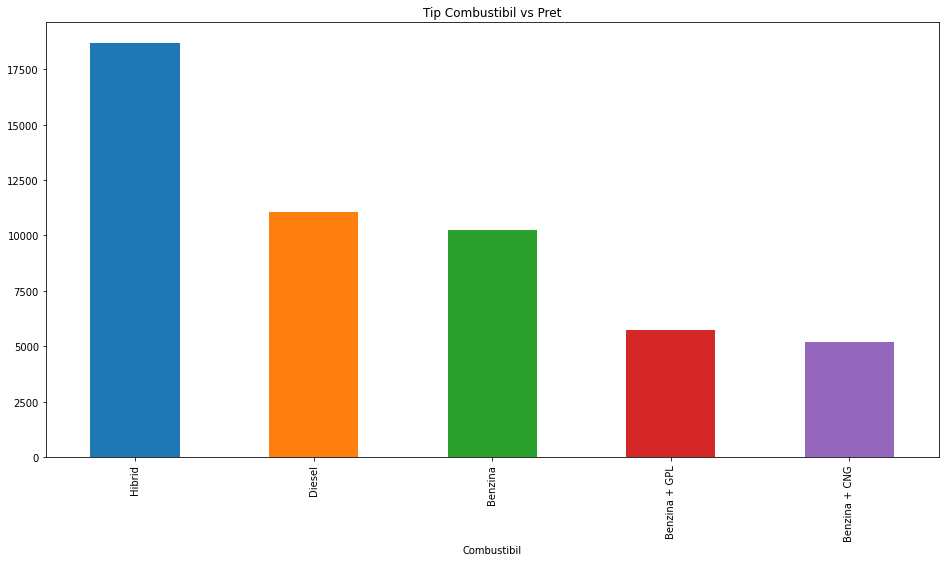

In [65]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
df_fuel = df.groupby(['Combustibil'])['price'].mean().sort_values(ascending = False)
df_fuel.plot(
    title='Tip Combustibil vs Pret',
    xlabel="Combustibil",
    kind="bar", 
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.show()

### Visualizing categorical data
##### Categorical data
- brand
- model
- fuel type
- car body
- door number
- drive wheel (front, back, 4x4)
- status new / used

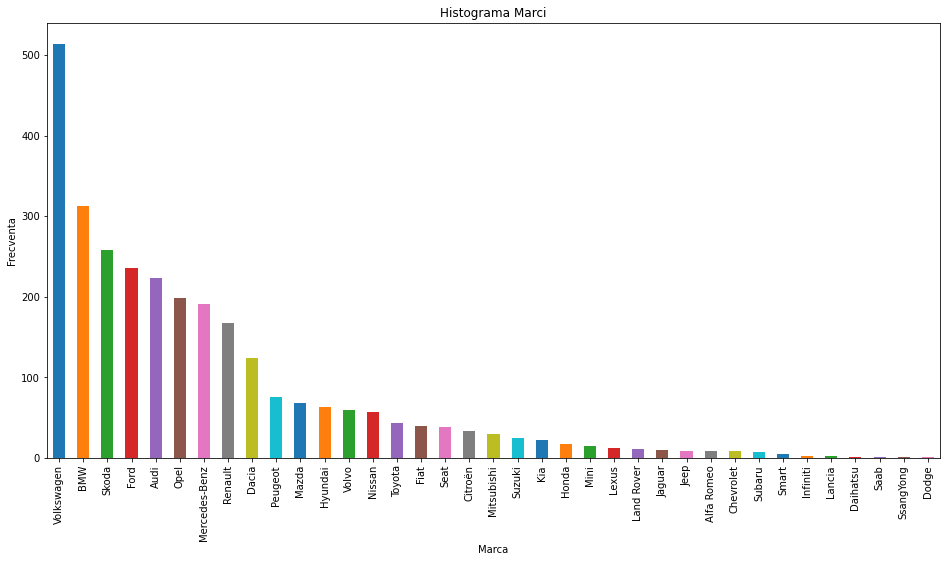

In [66]:
plt.figure(figsize=(16, 8))
df['Marca'].value_counts().plot(
    title='Histograma Marci',
    xlabel = 'Marca', 
    ylabel='Frecventa',
    kind='bar', 
    color=plt.cm.tab10(np.arange(len(df['Marca'])) % plt.cm.tab10.N)
)
plt.show()

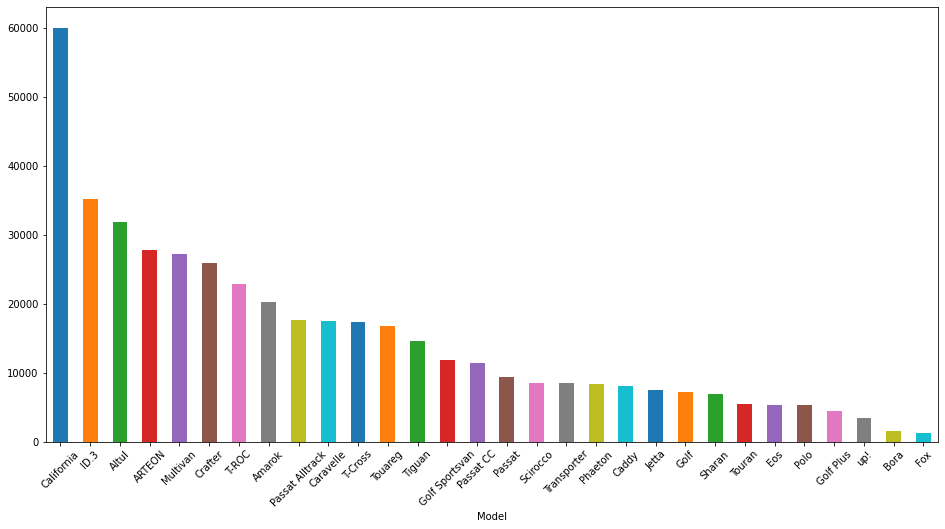

In [12]:
# Hist by models
df_vw = df[df.Marca == 'Volkswagen']
df_vw.head()
g_vw = df_vw.groupby('Model')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
g_vw.plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(g_vw)) % plt.cm.tab10.N),
    rot=45
)
plt.show()

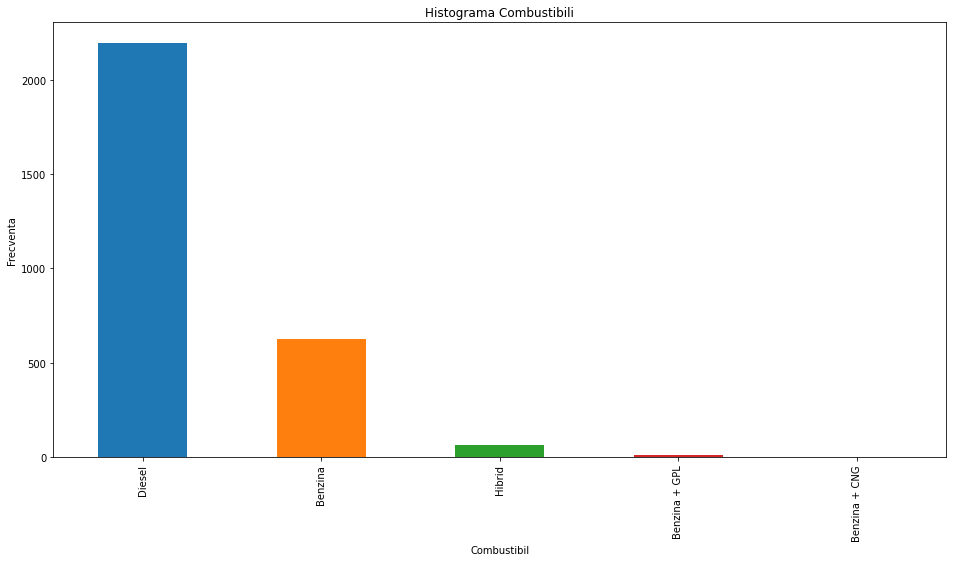

In [67]:
plt.figure(figsize=(16, 8))
df.Combustibil.value_counts().plot(
    title='Histograma Combustibili',
    xlabel = 'Combustibil', 
    ylabel='Frecventa',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.show()

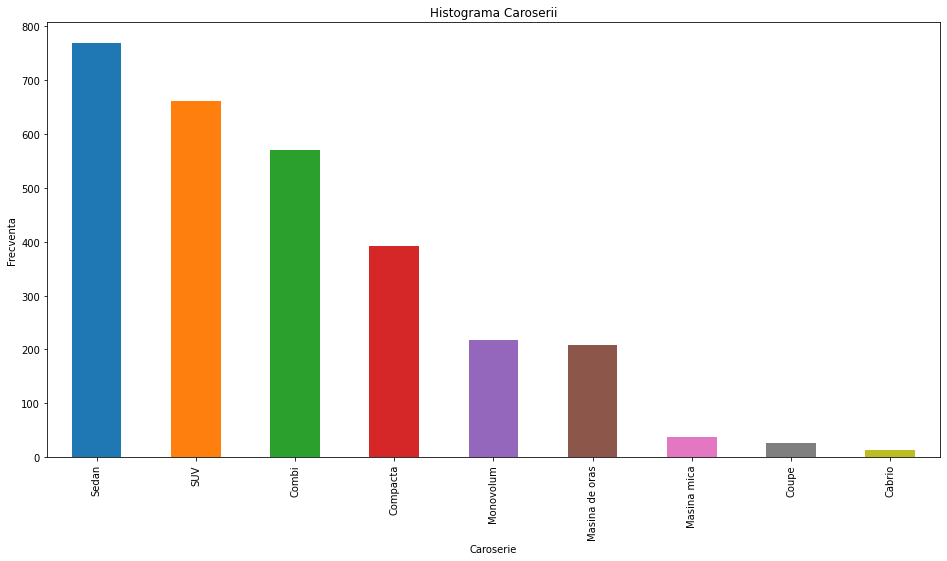

In [68]:
plt.figure(figsize=(16, 8))
df['Caroserie'].value_counts().plot(
    title='Histograma Caroserii',
    xlabel = 'Caroserie', 
    ylabel='Frecventa',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df['Caroserie'])) % plt.cm.tab10.N)
)
plt.show()

[Text(0.5, 0, 'An'), Text(0, 0.5, 'Frecventa')]

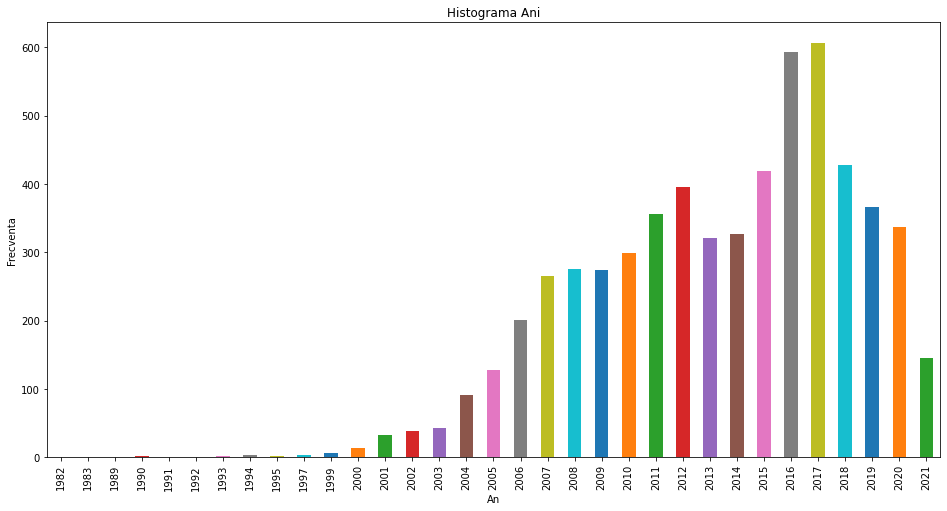

In [15]:
plt.figure(figsize=(16, 8))
plt1 = df.fabrication_year.value_counts().sort_index().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.fabrication_year)) % plt.cm.tab10.N)
)

plt.title('Histograma Ani')
plt1.set(xlabel = 'An', ylabel='Frecventa')

## Numerical data visualization

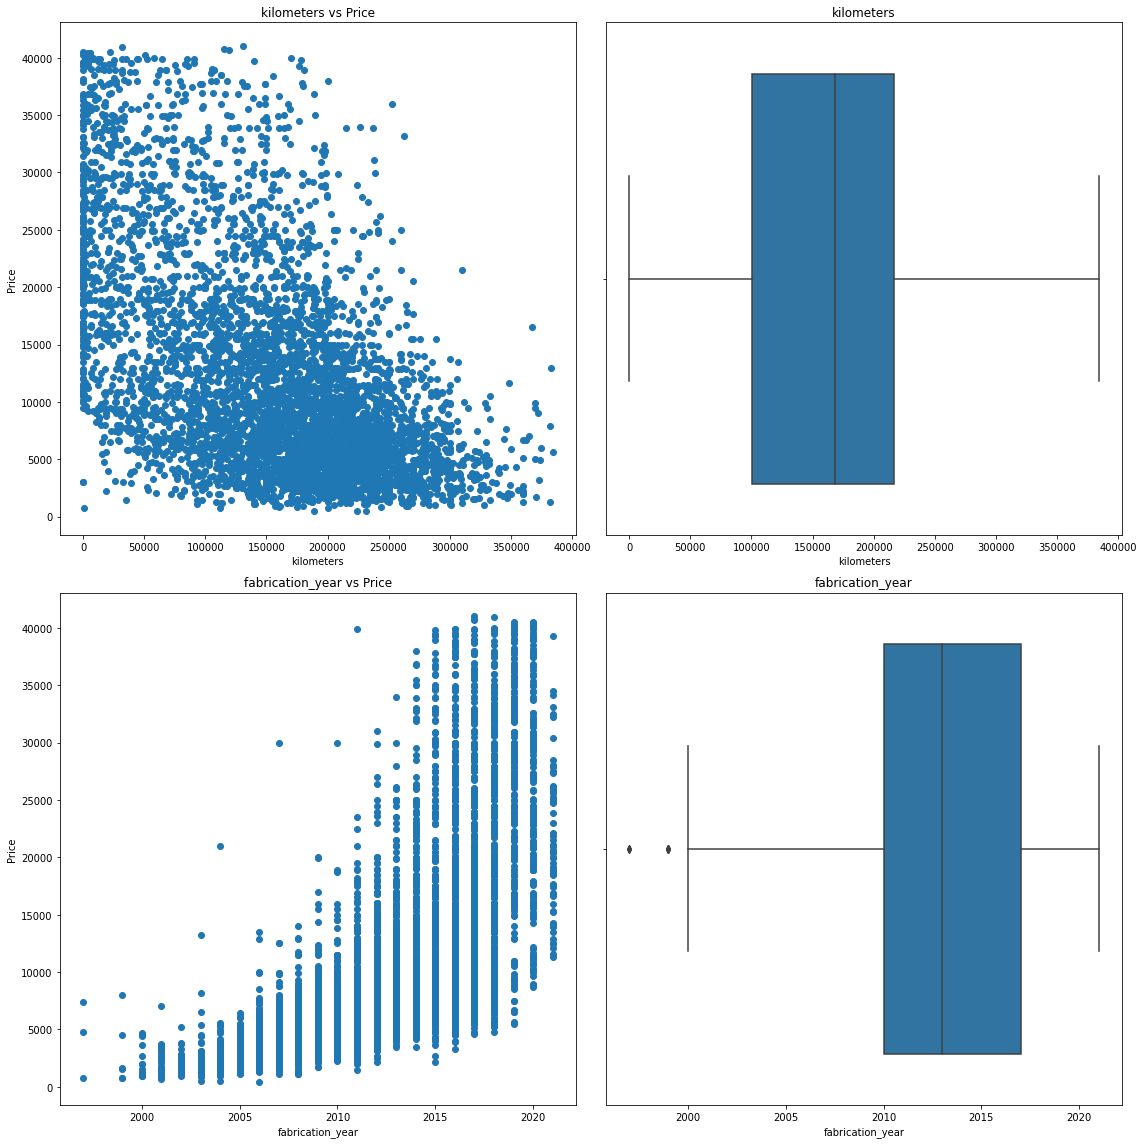

In [16]:
def remove_outliers(x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3 - Q1 # IQR is interquartile range. 
    filter = (df[x] >= Q1 - 1.5 * IQR) & (df[x] <= Q3 + 1.5 * IQR)
    return df.loc[filter]  

def scatter(x, fig):
    plt.subplot(2, 2, fig)
    plt.scatter(df[x], df['price'])
    plt.title(x + ' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

def boxplot(x, fig):
    plt.subplot(2, 2, fig)
    sea.boxplot(df[x])
    plt.title(x)
    plt.xlabel(x)
    
def distplot(x, fig):
    plt.subplot(2, 2, fig)
    sea.distplot(df[x])
    plt.title(x)
    plt.xlabel(x)
    
# Filter price ourliers
df = remove_outliers('price')

plt.figure(figsize=(16, 16))

df = remove_outliers('kilometers')
scatter('kilometers', 1)
boxplot('kilometers', 2)

df = remove_outliers('fabrication_year')
scatter('fabrication_year', 3)
boxplot('fabrication_year', 4)

plt.tight_layout()

### 

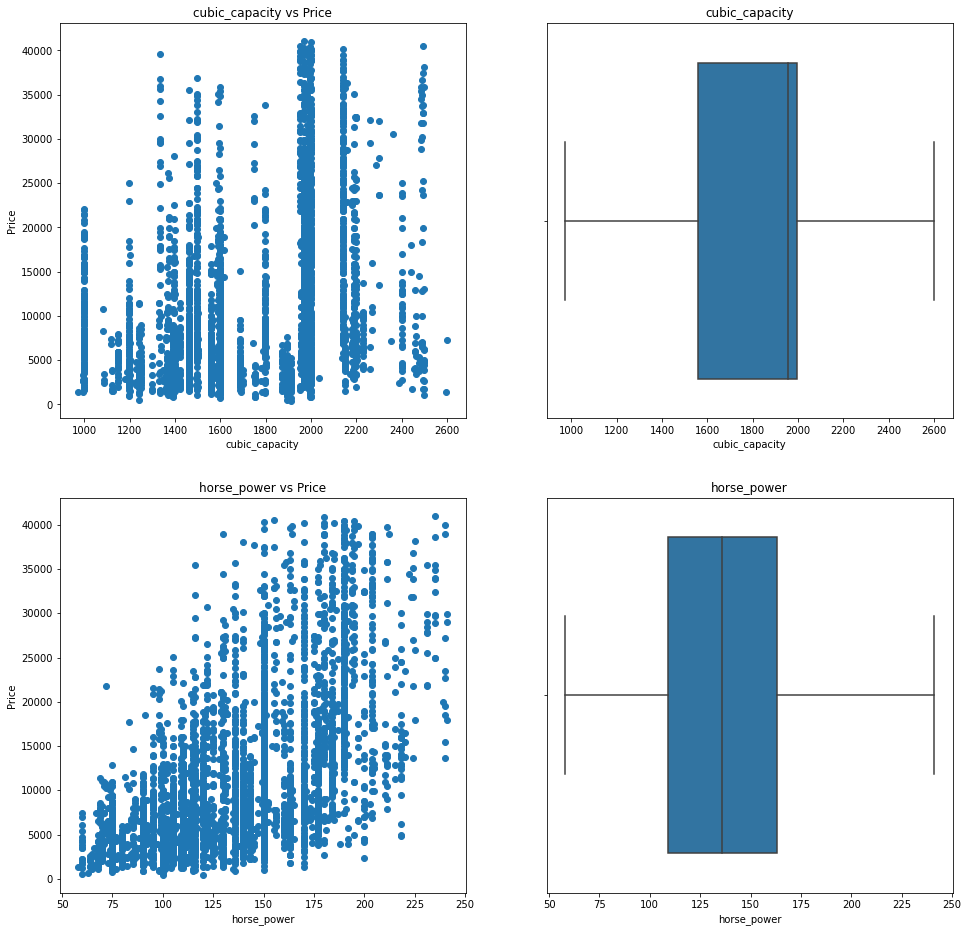

In [17]:
plt.figure(figsize=(16, 16))

df = remove_outliers('cubic_capacity')
scatter('cubic_capacity', 1)
boxplot('cubic_capacity', 2)

df = remove_outliers('horse_power')
scatter('horse_power', 3)
boxplot('horse_power', 4)

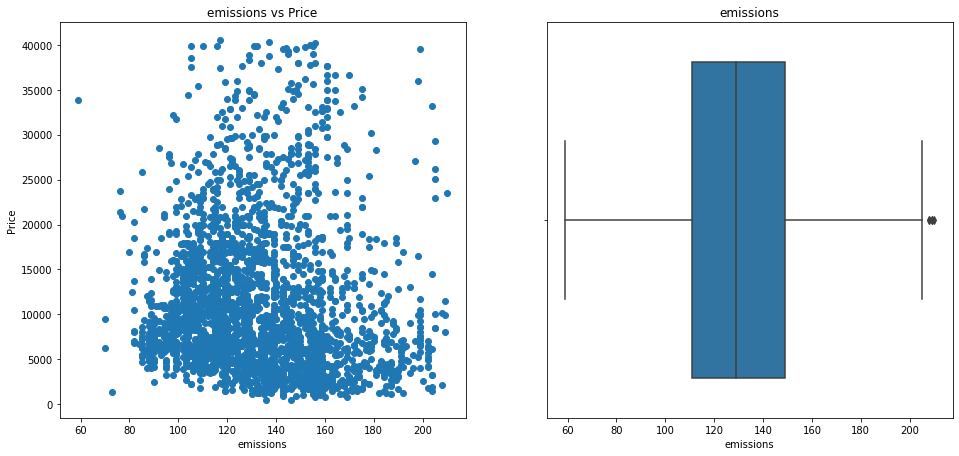

In [18]:
plt.figure(figsize=(16, 16))

df = remove_outliers('emissions')
scatter('emissions', 1)
boxplot('emissions', 2)

### Cars by prices

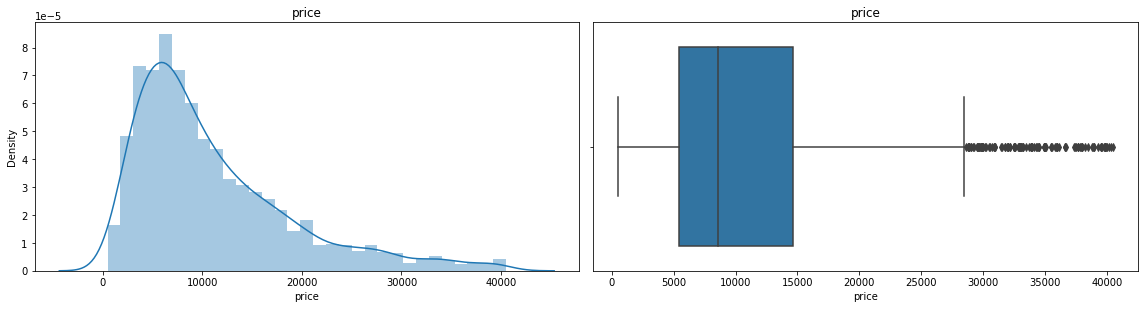

In [19]:
plt.figure(figsize=(16, 8))
distplot('price', 1)
boxplot('price', 2)
plt.tight_layout()

## Total valid df ads after pruning

In [73]:
df['id'].size

2899

### Correleation coef. between fab year and km

In [20]:
np.corrcoef(df['fabrication_year'], df['kilometers'])[0, 1]

-0.6570952623249845

### Bivariate Analysis fab year and km

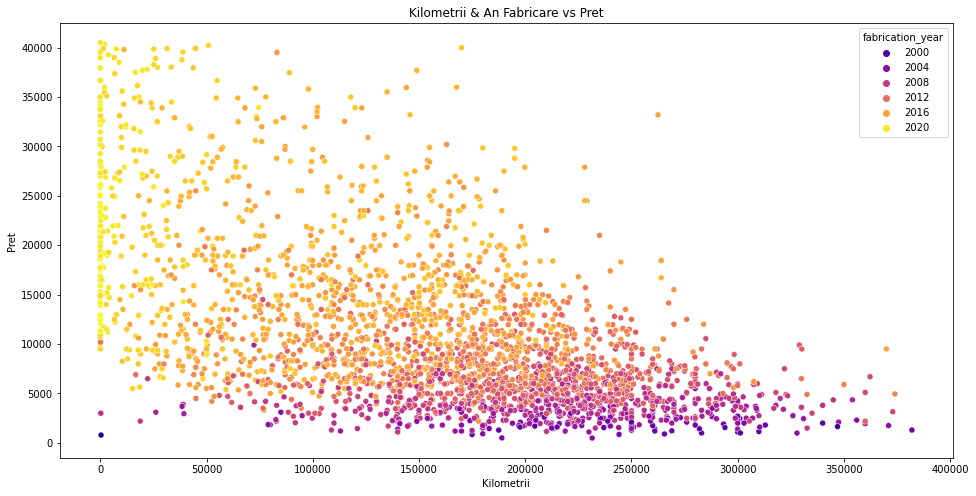

In [21]:
plt.figure(figsize=(16, 8))
plt.title('Kilometrii & An Fabricare vs Pret')
sea.scatterplot(x=df['kilometers'], y=df['price'], hue=df['fabrication_year'], palette=plt.cm.plasma)
plt.xlabel('Kilometrii')
plt.ylabel('Pret')

plt.show()

### Significant variables after visual analysis:
- price
- brand / model
- fuel type / technology
- body type
- kilometers (negative coeff)
- horse power
- fabrication year

## Building a model

In [77]:
df_model = df[[
    'price', 
#     'budget_range', 
#     'brand_model',
#     'Marca', 
#     'Model', 
#     'fuel', 
#     'Caroserie', 
    'kilometers', 
#     'cubic_capacity', 
    'horse_power', 
    'fabrication_year', 
#     'emissions'
]]
df_model.head()

,price,kilometers,horse_power,fabrication_year
2,8500,260000,180.0,2011
4,7000,147000,120.0,2015
5,7150,257000,116.0,2011
8,6750,119000,110.0,2015
9,39542,38850,190.0,2019


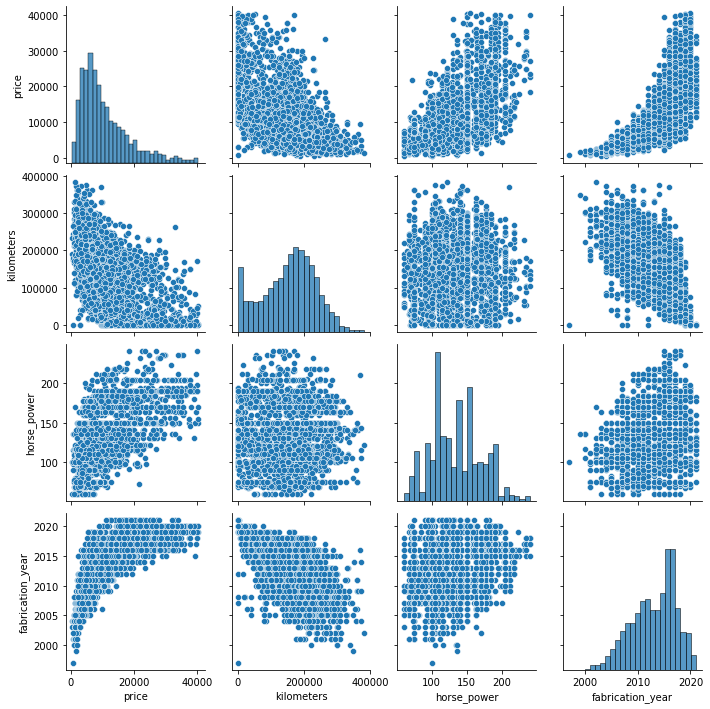

In [76]:
sea.pairplot(df_model)
plt.show()

## Dummy vars for categorical

In [24]:
# Defining the map function
def dummies(x):
    temp = pd.get_dummies(df_model[x], drop_first = True)
    df_dummies = pd.concat([df_model, temp], axis = 1)
    df_dummies.drop([x], axis = 1, inplace = True)
    return df_dummies

# df_model = dummies('budget_range')
# df_model = dummies('Marca')
# df_model = dummies('brand_model')
# df_model = dummies('fuel')
# df_model = dummies('Caroserie')
# df_model = dummies('emissions')

df_model.head()

,price,kilometers,horse_power,fabrication_year
2,8500,260000,180.0,2011
4,7000,147000,120.0,2015
5,7150,257000,116.0,2011
8,6750,119000,110.0,2015
9,39542,38850,190.0,2019


In [25]:
df_model.shape

(2899, 4)

In [26]:
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


# clean of NaN, inf, -inf
df_model = clean_dataset(df_model)
np.random.seed(0)

# split data 
df_train, df_test = train_test_split(df_model, train_size = 0.8, test_size = 0.2, random_state = 100)

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_vars = [
    'price', 
    'kilometers', 
#     'cubic_capacity', 
    'horse_power', 
    'fabrication_year', 
#     'emissions'
]
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [28]:
df_train.describe()

,price,kilometers,horse_power,fabrication_year
count,2319.000000,2319.000000,2319.000000,2319.000000
mean,0.259861,0.407902,0.407374,0.672255
std,0.197854,0.207078,0.201005,0.184942
min,0.000000,0.000000,0.000000,0.000000
25%,0.119029,0.264396,0.250000,0.541667
50%,0.200265,0.431936,0.388889,0.708333
75%,0.345240,0.552355,0.533333,0.833333
max,1.000000,1.000000,1.000000,1.000000


### Highly correlated variables to price

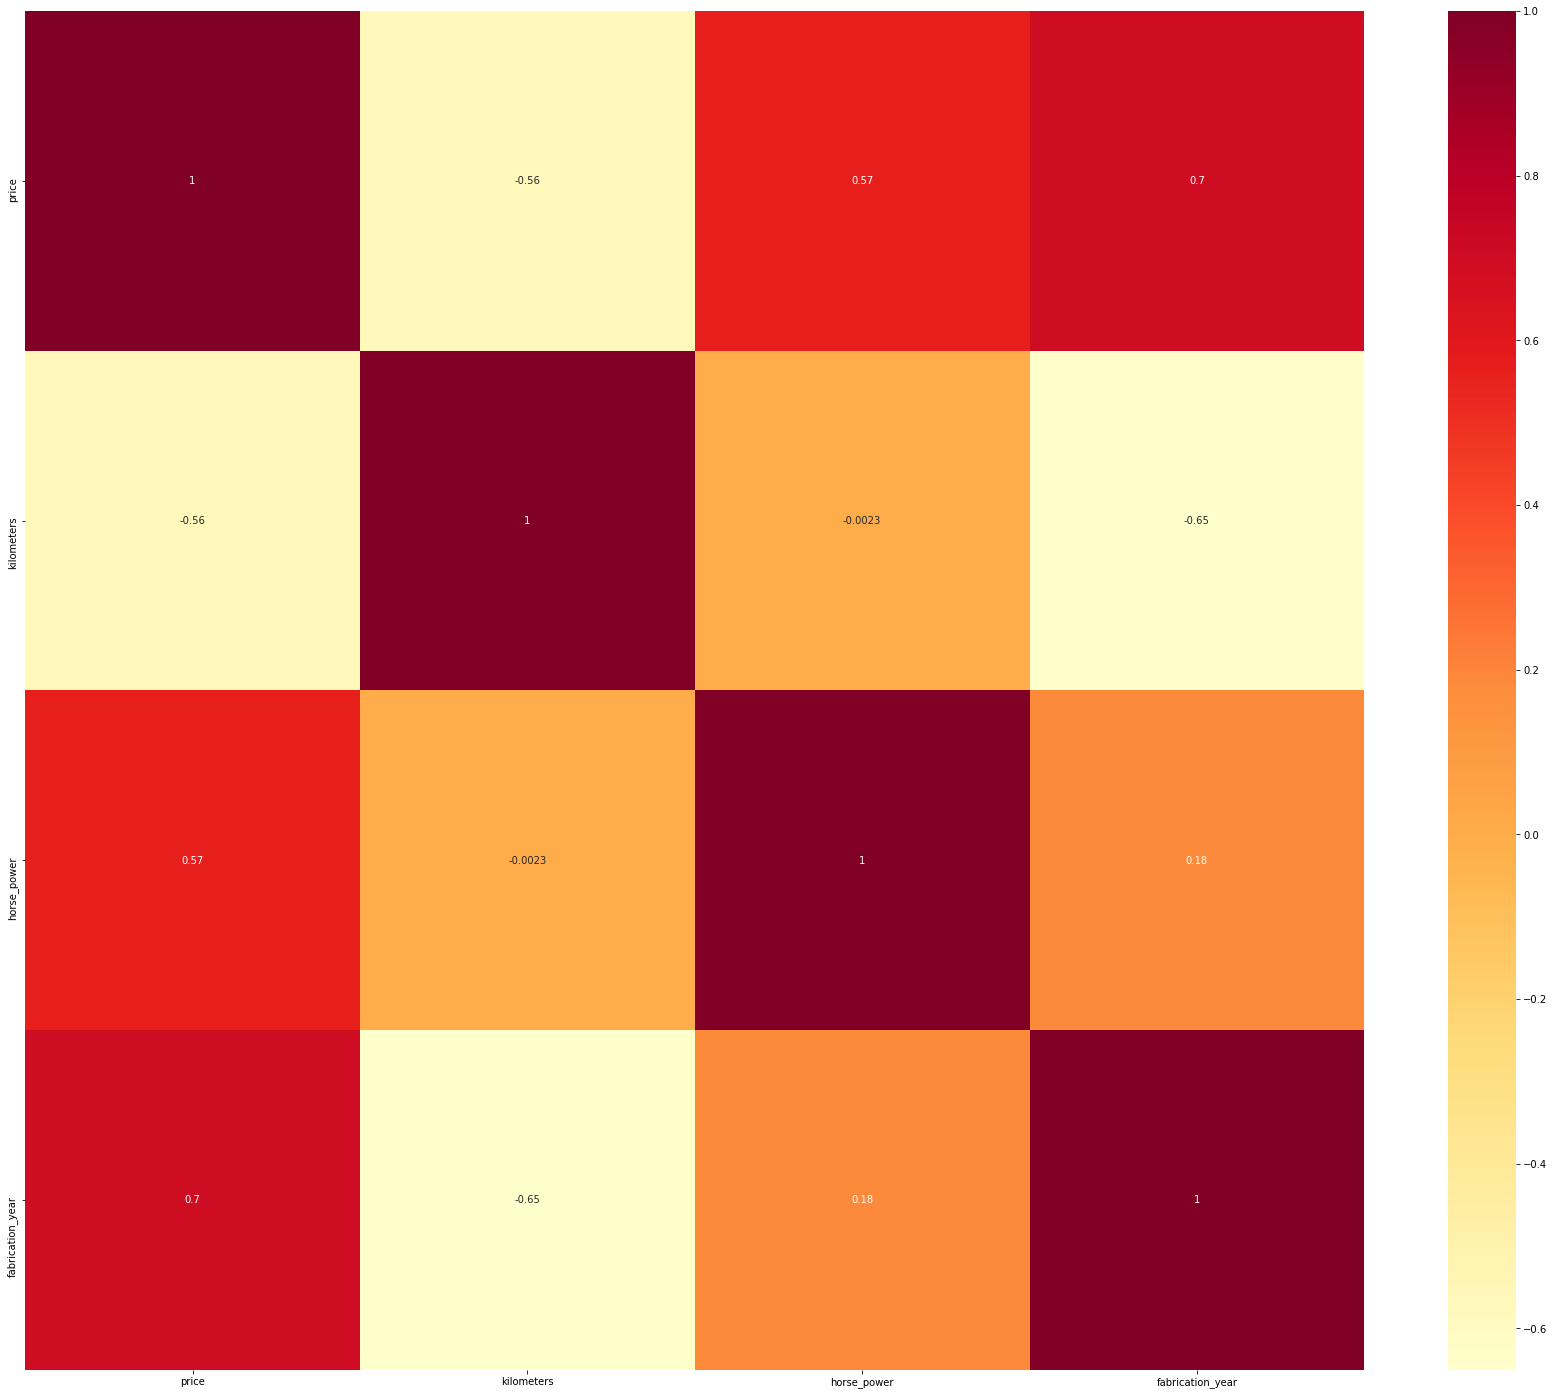

In [29]:
plt.figure(figsize = (30, 25))
sea.heatmap(df_train.corr(), annot = True, cmap="YlOrRd")
plt.show()

### Dividing into X, y

In [30]:
y_train = df_train.pop('price')
X_train = df_train

if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
    raise Exception

X_train.head()

,kilometers,horse_power,fabrication_year
5399,0.615182,0.572222,0.416667
1881,0.460732,0.500000,0.666667
163,0.000000,0.388889,1.000000
4644,0.579630,0.300000,0.250000
3755,0.788625,0.311111,0.125000


### Model building

In [31]:
# Recursive feature elimination
# Pruning low correlation coef. features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10, verbose=1)
rfe = rfe.fit(X_train, y_train)

In [32]:
# Show list with supported features and ranking
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('kilometers', True, 1),
 ('horse_power', True, 1),
 ('fabrication_year', True, 1)]

In [33]:
X_train.columns[rfe.support_]

Index(['kilometers', 'horse_power', 'fabrication_year'], dtype='object')

In [34]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,kilometers,horse_power,fabrication_year
5399,0.615182,0.572222,0.416667
1881,0.460732,0.500000,0.666667
163,0.000000,0.388889,1.000000
4644,0.579630,0.300000,0.250000
3755,0.788625,0.311111,0.125000


## Build model 1

In [47]:
def build_model(X, y):
    X = sm.add_constant(X) # adding the constant
    lm = sm.OLS(y, X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [80]:
X_train_new = build_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     2164.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:14:08   Log-Likelihood:                 2016.6
No. Observations:                2319   AIC:                            -4025.
Df Residuals:                    2315   BIC:                            -4002.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1365      0.014  

##### Parameters which have a p-val over 0.05 alfa, statistically insignificant, droping

In [81]:
# X_train_new = X_train_new.drop(['Medium'], axis = 1)
# X_train_new = build_model(X_train_new, y_train)

### Variance Inflation Factor Calculations

In [82]:
checkVIF(X_train)

,Features,VIF
1,horse_power,5.38
2,fabrication_year,5.00
0,kilometers,2.98


## Residual analysis of model

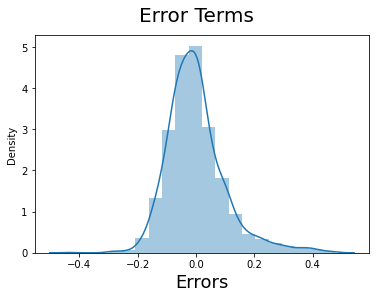

In [83]:
lm = sm.OLS(y_train, X_train_new).fit()
y_train_price = lm.predict(X_train_new)

# Plot the histogram of the error terms
fig = plt.figure()
sea.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)
plt.show()

Error terms seem to be approximately normally distributed, so the assumption on the linear modeling seems to be fulfilled.

In [84]:
# Scaling the test set
num_vars = [
    'price', 
            'kilometers', 
#             'cubic_capacity', 
            'horse_power', 
            'fabrication_year', 
#             'emissions'
]
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [85]:
# Dividing into X and y
X_test = df_test
y_test = df_test.copy().pop('price')

In [86]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const', axis=1)

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [87]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [88]:
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.7452584850760438

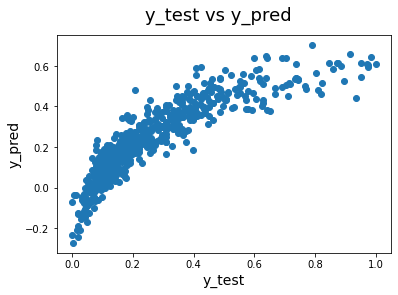

In [91]:
# EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=18)
plt.xlabel('y_test', fontsize=14)
plt.ylabel('y_pred', fontsize=14)
plt.show()

#### Evaluation of the model using Statistics

In [90]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     2164.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:14:32   Log-Likelihood:                 2016.6
No. Observations:                2319   AIC:                            -4025.
Df Residuals:                    2315   BIC:                            -4002.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1365      0.014  

R-squred and Adjusted R-squared (extent of fit) - 0.899 and 0.896 - 90% variance explained.

F-stats and Prob(F-stats) (overall model fit) - 308.0 and 1.04e-67(approx. 0.0) - Model fir is significant and explained 90% variance is just not by chance.

p-values - p-values for all the coefficients seem to be less than the significance level of 0.05. - meaning that all the predictors are statistically significant.